In [1]:
!pip install tensorflow

Looking in indexes: https://artifactory.blackstone.com/artifactory/api/pypi/python/simple

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.


  Using cached https://artifactory.blackstone.com/artifactory/api/pypi/python/packages/packages/08/36/6589c7d5fc4fecda63de4453fefff7c58f6de2b1bb7dfbe7fa807bf85c46/numpy-1.23.5-cp39-cp39-win_amd64.whl (14.7 MB)
  Using cached https://artifactory.blackstone.com/artifactory/api/pypi/python/packages/packages/99/2e/de8dcdbe1579b96f202685d8811d864291c374ea5fce13c63c70fdaf905d/numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


In [2]:
import tensorflow.keras as keras # tf is a low model, every little detail, keras is high level api that they wrapped in tf2 
from tensorflow.keras.preprocessing import image # this is dependant on a lib pip install pillow 
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top =True) # this means use the weights from when you trained the network on imagenet
model.summary()
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
import glob 
import random 
image_files = glob.glob('./images/*.jpg')

In [5]:
random.shuffle(image_files)

In [6]:
import numpy as np
features = []

# for i, image_path in zip(range(0,len(image_files)), image_files) # same as below 

for i, image_path in enumerate(image_files): #it takes image_files and goes through and gives you each item and its associated index 
    if i % 10 == 0:
        print("analyzed " + str(i) + " out of " + str(len(image_files)))
    
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img) # turning it into a numpy array 
    #print(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print(x)
    
    feat = feat_extractor.predict(x)[0] # grabbing first value out of that prediction 
    #print(len(feat))
    features.append(feat)

analyzed 0 out of 40
1/1 [==============================] - 1s 525ms/step
analyzed 10 out of 40
1/1 [==============================] - 0s 478ms/step
analyzed 20 out of 40
1/1 [==============================] - 0s 490ms/step
analyzed 30 out of 40
1/1 [==============================] - 0s 475ms/step


In [7]:
# this is pre processing and transfors your data into an array using its features 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # this is sensitive to distance, so standardscaler normalizes it to distance 

ss = StandardScaler()
scaled = ss.fit_transform(features)
scaled[0] # looks like everything is btwn 1 and -1 

array([-0.33246682,  3.55678354,  4.32971405, ...,  3.307292  ,
       -0.41301908, -0.49437718])

In [8]:
# this clusters the image 
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(scaled)
clusters

array([0, 1, 1, 2, 3, 1, 3, 3, 2, 3, 3, 3, 2, 0, 3, 2, 2, 3, 3, 3, 2, 2,
       3, 2, 4, 1, 3, 3, 1, 3, 0, 1, 3, 2, 0, 3, 4, 3, 3, 2])

In [9]:
# plots it using k nearst neights 
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)
#cosine works better in high dimension space, we haven't done any dimentionality reduction 

In [10]:
closest # index of all the images, 1st image, and the top 5 image by distance, list of a list 

array([[30, 13,  0, 34,  1],
       [ 5, 28,  1, 25,  2],
       [ 3,  8, 20, 12, 16],
       [38, 18, 29, 35,  4],
       [36, 24, 18, 38,  7]], dtype=int64)

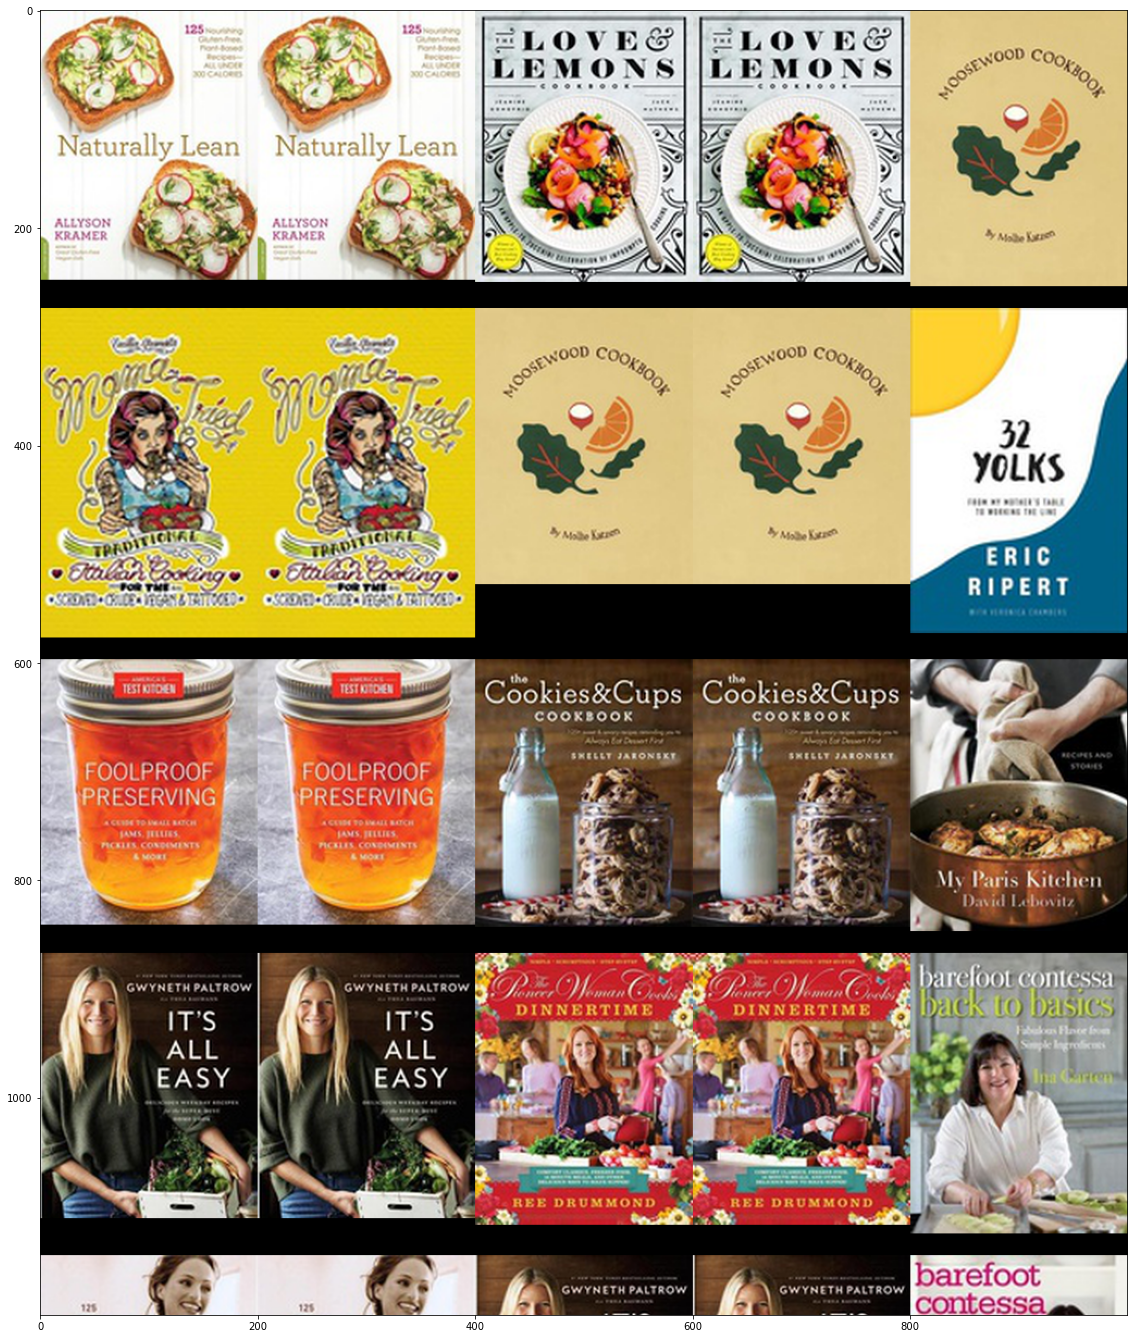

In [11]:
# plots it on a chart 

from PIL import Image
import matplotlib.pyplot as plt

img_width = 200

grid_image = Image.new('RGB', (5 * img_width, len(closest) * 240), (0, 0, 0, 255))

max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(image_files[col_num])
        img_ar = img.width / img.height
        img = img.resize((img_width, int(img_width / img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp, img.height)
        grid_image.paste(img, (xpos, max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20 # adding 20 pixel margin

plt.figure(figsize = (32,24))
plt.imshow(grid_image)

In [12]:
#!pip uninstall umap

^C


In [20]:
!pip install --user umap-learn

Looking in indexes: https://artifactory.blackstone.com/artifactory/api/pypi/python/simple
  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached pynndescent-0.5.8-py3-none-any.whl


In [17]:
help(umap)

NameError: name 'umap' is not defined

In [20]:
#!pip install numpy==1.20

Looking in indexes: https://artifactory.blackstone.com/artifactory/api/pypi/python/simple
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.0 which is incompatible.
ml-dtypes 0.0.4 requires numpy>1.20, but you have numpy 1.20.0 which is incompatible.
jax 0.4.8 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [21]:
# UMAP is an algorithm for dimension reduction based on manifold learning techniques and ideas from topological data analysis
import umap.umap_ as umap
embedding = umap.UMAP().fit_transform(scaled)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

ModuleNotFoundError: No module named 'umap.umap_'